In [2]:
import numpy as np
from numpy import log
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pmdarima as pm
import os
import math
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA


In [5]:
spy = pd.read_csv('spy_processed.csv')

In [6]:
cp = spy.iloc[:,[0,6,7,11]]
cp = cp.rename({'Close' : 'clo', 'Adj Close' : 'adc', 'Unnamed: 0.1' : 'no'}, axis =1 )

NOTE: The following 3 sections for finding p, d, q individually are not used in the generation of final result. Instead we use auto ARIMA.

### Order of differencing -- d

In [ ]:
plot_acf(cp.ret.dropna());

In [ ]:
result = adfuller(cp.ret)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

### Order of AR term -- p

In [ ]:
# check partial autocorrelation

plot_pacf(cp.ret.dropna(), method = 'ywm')
plt.show()

### Order of MA term -- q

In [ ]:
# check autocorrelation

plot_acf(cp.ret.dropna());

# ARIMA Model

In [7]:
model = ARIMA(cp.ret, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    ret   No. Observations:                 7091
Model:                 ARIMA(1, 1, 1)   Log Likelihood               21338.193
Date:                Tue, 19 Apr 2022   AIC                         -42670.387
Time:                        22:02:11   BIC                         -42649.787
Sample:                             0   HQIC                        -42663.293
                               - 7091                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0885      0.006    -14.415      0.000      -0.101      -0.076
ma.L1         -0.9999      0.009   -112.676      0.000      -1.017      -0.982
sigma2         0.0001   1.61e-06     87.937      0.0

/Users/pablomjlee/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

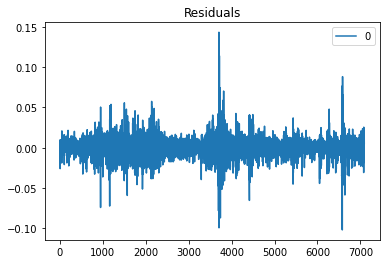

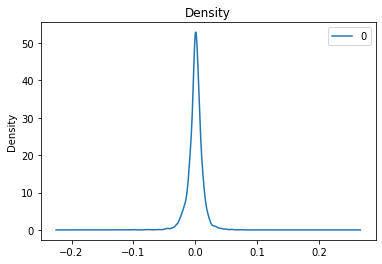

In [8]:
# residual plot

residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title="Residuals")
residuals.plot(kind='kde', title='Density')

# auto ARIMA

In [13]:
# auto arima algorithm -- find the best combination for parameters

model_auto = pm.auto_arima(cp.ret, start_p = 1, start_q = 1,
                      test = 'adf',       
                      max_p = 3, max_q = 3, 
                      m = 1,              
                      d = None,           
                      seasonal = False,   
                      start_P = 0, 
                      D = 0, 
                      trace = True,
                      error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-42683.533, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-42627.806, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-42678.722, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-42681.417, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-42680.776, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-42683.983, Time=0.30 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-42682.808, Time=0.61 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-42682.447, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-42679.307, Time=0.51 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-42681.035, Time=0.40 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-42676.905, Time=0.84 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-42697.923, Time=0.77 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-42694.415, Time=0.74 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-42695.632, Time=0.93 sec
 ARIM

# Predictions and prediction error

In [78]:
def arima_predictions(n, begin_ind, lag, show_plot=False):
    
    
    train = cp.ret[begin_ind - lag : begin_ind] # train set is from day (begin - lag) to begin day.
    history = [x for x in train]
    predictions = list()
    actual = list()
    close_price_pred = list()

    # rolling - forecast
    for t in range(n):
        model = ARIMA(history, order=(1,0,2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0] # predicted return
        predictions.append(yhat) 
        
        obs = cp.ret[begin_ind + t] 
        actual.append(cp.adc[begin_ind + t]) # test label
        history.append(obs) # add the new actual price into the history for next prediction
        
        close_price_pred.append(cp.adc[begin_ind + t - 1] * (1 + yhat))
        
        
    retdf = pd.concat([pd.DataFrame(close_price_pred), pd.DataFrame(actual)], axis = 1) 
    retdf.columns = ['pred', 'actual'] #dataframe: prediction and actual
       
        
    mse = np.sum(np.square(retdf["pred"] - retdf["actual"])) # calculate MSE
    print('MSE : %f' % mse)

    # plot of predicted values and actual prices.
    if show_plot:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1) 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
     
        plt.plot(spy.Date[begin_ind:begin_ind+n], retdf["pred"],"o-", markersize=3, label="predicted")
        plt.plot(spy.Date[begin_ind:begin_ind+n], retdf["actual"], "o-", markersize=3, label="actual")
        
        plt.ylabel("Adjusted Close")
        plt.legend(loc="lower right", fontsize=20)
        plt.savefig('ARIMA_resultplot.png')

        
    return retdf
    

MSE : 137.721730


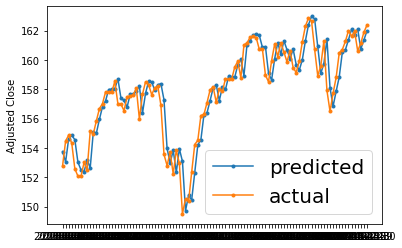

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = arima_predictions(100, 5000, 50, show_plot = True)

In [41]:
res

,pred,actual
0,153.757630,152.770416
1,153.054374,154.477875
2,154.643820,154.870636
3,154.861320,154.315674
4,154.560610,152.582535
...,...,...
95,161.697930,161.942429
96,162.106817,160.614670
97,160.737973,161.123398
98,161.344103,161.873459


# FINAL RESULTS

MSE : 5286.955332


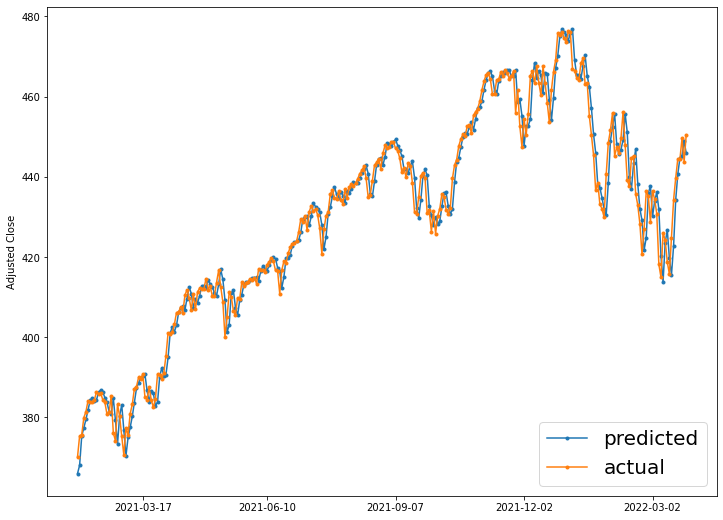

In [79]:
plt.rcParams["figure.figsize"] = (12, 9) 

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    finres = arima_predictions(290, 6800, 700, show_plot = True)